### Seq2Seq

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import pandas as pd
from collections import Counter

# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Encoder

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hid_dim)     # IF U R USING RNN ---> self.rnn = nn.RNN(emb_dim, hid_dim)

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, (hidden, cell) = self.lstm(embedded)
        return hidden, cell

        '''# RNN version
        outputs, hidden = self.rnn(embedded)
        return hidden, None'''

# Decoder

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hid_dim)     # IF U R USING RNN ----> self.rnn = nn.RNN(emb_dim, hid_dim)
        self.fc_out = nn.Linear(hid_dim, output_dim)

    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)
        embedded = self.embedding(input)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(0))
        return prediction, hidden, cell

        ''' # RNN version
        output, hidden = self.rnn(embedded, hidden)
        prediction = self.fc_out(output.squeeze(0))
        return prediction, hidden, None'''

# Seq2Seq Model

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.embedding.num_embeddings

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(device)
        hidden, cell = self.encoder(src)  # RNN version hidden = self.encoder(src)

        input = trg[0, :]  # <sos>
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)    # RNN version output, hidden, _ = self.decoder(input, hidden, None)
            outputs[t] = output
            top1 = output.argmax(1)
            input = trg[t] if random.random() < teacher_forcing_ratio else top1

        return outputs

# Data Example

def build_vocab(sentences, min_freq=1):
    counter = Counter(word for sent in sentences for word in sent)
    vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

def sentence_to_tensor(vocab, sentence):
    tokens = [vocab[word] for word in sentence]
    tokens = [vocab['<sos>']] + tokens + [vocab['<eos>']]
    return torch.tensor(tokens, dtype=torch.long).unsqueeze(1).to(device)  # [len, 1]


# Load and prepare
data = pd.read_csv("/content/seq2seq.csv", encoding = 'latin-1')
data["Source"] = data["Source"].apply(lambda x: x.lower().strip().split())
data["Target"] = data["Target"].apply(lambda x: x.lower().strip().split())

SRC_vocab = build_vocab(data["Source"])
TRG_vocab = build_vocab(data["Target"])
SRC_itos = {i: s for s, i in SRC_vocab.items()}
TRG_itos = {i: s for s, i in TRG_vocab.items()}

example_src = data["Source"][0]
example_trg = data["Target"][0]
src_tensor = sentence_to_tensor(SRC_vocab, example_src)
trg_tensor = sentence_to_tensor(TRG_vocab, example_trg)

INPUT_DIM = len(SRC_vocab)
OUTPUT_DIM = len(TRG_vocab)
HID_DIM = 256
EMB_DIM = 128
N_EPOCHS = 100
LEARNING_RATE = 0.01

print(data['Source'])
print(data['Target'])
# Train Model

encoder = Encoder(INPUT_DIM, EMB_DIM, HID_DIM).to(device)
decoder = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM).to(device)
model = Seq2Seq(encoder, decoder).to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=TRG_vocab['<pad>'])

for epoch in range(N_EPOCHS):
    model.train()
    optimizer.zero_grad()
    output = model(src_tensor, trg_tensor)  # output: [trg_len, 1, output_dim]
    output_dim = output.shape[-1]

    output = output[1:].view(-1, output_dim)
    trg = trg_tensor[1:].view(-1)

    loss = criterion(output, trg)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} Loss: {loss.item():.4f}")

# Inference
def translate_sentence(model, sentence, src_vocab, trg_vocab, trg_itos, max_len=10):
    model.eval()
    src_tensor = sentence_to_tensor(src_vocab, sentence)
    hidden, cell = model.encoder(src_tensor)

    input = torch.tensor([trg_vocab['<sos>']], device=device)

    translated_tokens = []

    for _ in range(max_len):
        output, hidden, cell = model.decoder(input, hidden, cell)
        top1 = output.argmax(1).item()
        if top1 == trg_vocab['<eos>']:
            break
        translated_tokens.append(trg_itos[top1])
        input = torch.tensor([top1], device=device)

    return translated_tokens

input_sentence = "yes"
tokens = input_sentence.lower().split()  # ['hello', 'how', 'are', 'you']
print("Translation:", translate_sentence(model, tokens, SRC_vocab, TRG_vocab, TRG_itos))

0            [hello]
1    [good, morning]
2    [how, are, you]
3       [thank, you]
4      [good, night]
5              [yes]
6               [no]
7           [please]
8          [goodbye]
9          [welcome]
Name: Source, dtype: object
0              [hola]
1      [buenos, días]
2       [cómo, estás]
3           [gracias]
4    [buenas, noches]
5                [sí]
6                [no]
7        [por, favor]
8             [adiós]
9        [bienvenido]
Name: Target, dtype: object
Epoch 0 Loss: 2.8018
Epoch 10 Loss: 0.0004
Epoch 20 Loss: 0.0001
Epoch 30 Loss: 0.0000
Epoch 40 Loss: 0.0000
Epoch 50 Loss: 0.0000
Epoch 60 Loss: 0.0000
Epoch 70 Loss: 0.0000
Epoch 80 Loss: 0.0000
Epoch 90 Loss: 0.0000
Translation: ['hola']


### Sentiment Analysis

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-44-d20f5cfcd56c>:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.731900,0.671496
2,0.694800,0.669193
3,0.637300,0.663116


Device set to use cpu


[[{'label': 'LABEL_1', 'score': 0.5041696429252625}, {'label': 'LABEL_0', 'score': 0.49583035707473755}]]
[[{'label': 'LABEL_0', 'score': 0.5168720483779907}, {'label': 'LABEL_1', 'score': 0.4831279218196869}]]



🟢 Accuracy: 0.5000

🟢 Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         1
    positive       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


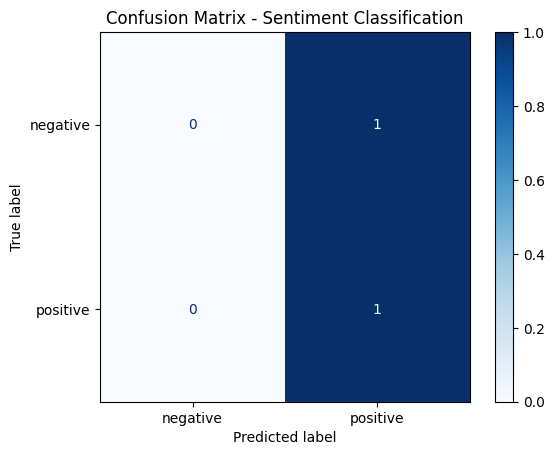

In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, TrainingArguments, Trainer, TextClassificationPipeline
from sklearn.preprocessing import LabelEncoder
import torch

# Load and encode dataset
df = pd.read_csv("sentiment.txt")
le = LabelEncoder()
df["label"] = le.fit_transform(df["label"])  # positive=1, negative=0

dataset = Dataset.from_pandas(df)

# Load tokenizer and tokenize dataset
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

dataset = dataset.map(tokenize, batched=True)
dataset = dataset.train_test_split(test_size=0.2)

# Load model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Define training args
training_args = TrainingArguments(
    output_dir="output",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    evaluation_strategy="epoch",
    save_strategy="no",
    logging_strategy="epoch",
    report_to="none"  # Disable WandB logging
)


# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer
)

# Fine-tune
trainer.train()

pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k=None)

print(pipe("I love this!"))
print(pipe("This is bad."))

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# 🧪 Get true labels and predicted labels
test_dataset = dataset["test"]
true_labels = test_dataset["label"]

# 🔍 Get model predictions on test set
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

# ✅ Accuracy and Classification Report
accuracy = accuracy_score(true_labels, preds)
print(f"\n🟢 Accuracy: {accuracy:.4f}\n")
print("🟢 Classification Report:")
print(classification_report(true_labels, preds, target_names=le.classes_))

# 📊 Confusion Matrix
cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Sentiment Classification")
plt.show()

### Text Summarization

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-45-7bd2b725e84e>:47: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,15.011500,16.805227
2,14.379200,16.400494
3,14.146600,16.202503


🔹Generated Summary:
 material could be used to develop cheaper and more efficient solar panels. discovery seen as a major step in the fight against climate change.
🔸Reference Summary:
 Scientists created a material to improve solar panels and fight climate change.

🟢 BLEU Score: 0.0000


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


rouge1: 0.5000
rouge2: 0.1176
rougeL: 0.3889
rougeLsum: 0.3889


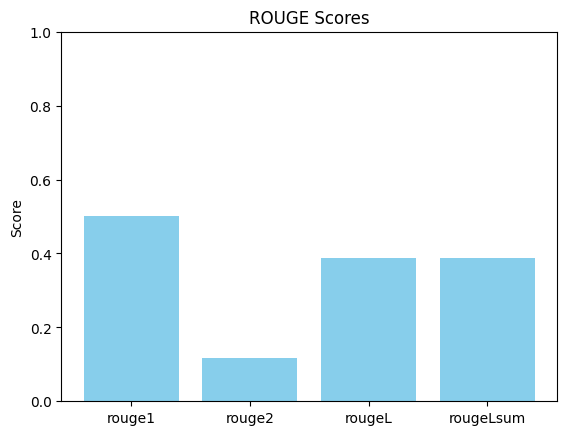

In [ ]:
import pandas as pd
import torch
import nltk
from datasets import Dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from nltk.translate.bleu_score import sentence_bleu
import evaluate
import matplotlib.pyplot as plt
#pip install rouge_score
#pip install evaluate
nltk.download("punkt")

# Load CSV
df = pd.read_csv("dummy_summarization_data.csv")

# Load tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

# Convert pandas to HF dataset
dataset = Dataset.from_pandas(df)

# Preprocessing function
def preprocess_function(examples):
    inputs = [f"summarize: {text}" for text in examples["article"]]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")
    labels = tokenizer(examples["summary"], max_length=64, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Tokenize and split dataset
dataset = dataset.map(preprocess_function, batched=True)
dataset = dataset.train_test_split(test_size=0.3, seed=42)
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Training arguments
training_args = TrainingArguments(
    output_dir="./output",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    report_to="none"
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer
)

trainer.train()

# Evaluation
sample_input = df.iloc[0]["article"]
input_ids = tokenizer(f"summarize: {sample_input}", return_tensors="pt", max_length=512, truncation=True).input_ids
output_ids = model.generate(input_ids, max_length=64, num_beams=4, early_stopping=True)
summary_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

print("🔹Generated Summary:\n", summary_text)
print("🔸Reference Summary:\n", df.iloc[0]["summary"])

# BLEU Score
bleu = sentence_bleu([nltk.word_tokenize(df.iloc[0]["summary"])], nltk.word_tokenize(summary_text))
print(f"\n🟢 BLEU Score: {bleu:.4f}")

# ROUGE Score
rouge = evaluate.load("rouge")
results = rouge.compute(predictions=[summary_text], references=[df.iloc[0]["summary"]])

for k, v in results.items():
    print(f"{k}: {v:.4f}")

plt.bar(results.keys(), results.values(), color="skyblue")
plt.title("ROUGE Scores")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()


### Machine Translation

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-46-98327210ca61>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,4.134100,1.038256
2,0.573900,0.211726
3,0.257100,0.161989


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[65000]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(



🔹 Predicted Translation:
 Hola, ¿cómo estás?
🔸 Reference Translation:
 Hola, cómo estás?

🟢 BLEU Score: 0.0000


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)



🟢 ROUGE Scores:
rouge1: 1.0000
rouge2: 1.0000
rougeL: 1.0000
rougeLsum: 1.0000


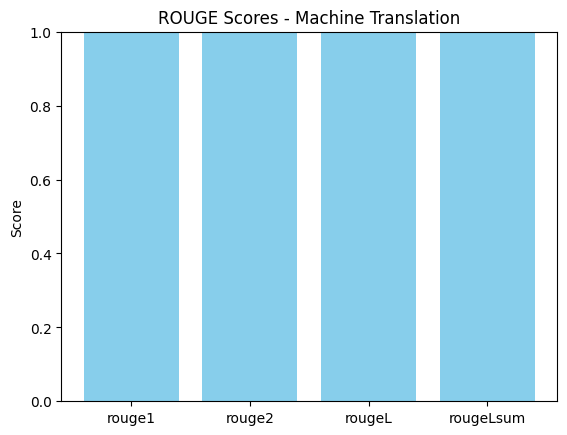

In [ ]:
import pandas as pd
from transformers import MarianMTModel, MarianTokenizer, Trainer, TrainingArguments
from nltk.translate.bleu_score import sentence_bleu
from nltk import word_tokenize, download
from datasets import Dataset
import evaluate
import matplotlib.pyplot as plt

download('punkt')

# Load dataset
df = pd.read_csv("seq2seq.csv", encoding='latin-1')

# Convert to HuggingFace Dataset
dataset = Dataset.from_pandas(df.rename(columns={"Source": "src", "Target": "tgt"}))

# Load model & tokenizer
model_name = "Helsinki-NLP/opus-mt-en-es"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

# Tokenization
def preprocess_data(batch):
    source = tokenizer(batch["src"], max_length=128, padding="max_length", truncation=True)
    target = tokenizer(batch["tgt"], max_length=128, padding="max_length", truncation=True)
    source["labels"] = target["input_ids"]
    return source

dataset = dataset.map(preprocess_data, batched=True)
dataset = dataset.train_test_split(test_size=0.2, seed=42)
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Training args
training_args = TrainingArguments(
    output_dir="output",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    report_to="none"
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer
)

trainer.train()

# Translate example and evaluate
def translate(text):
    tokens = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    translated = model.generate(**tokens, max_length=100)
    return tokenizer.decode(translated[0], skip_special_tokens=True)

def evaluate_translation(predicted, reference):
    print("\n🔹 Predicted Translation:\n", predicted)
    print("🔸 Reference Translation:\n", reference)

    bleu = sentence_bleu([word_tokenize(reference)], word_tokenize(predicted))
    print(f"\n🟢 BLEU Score: {bleu:.4f}")

    rouge = evaluate.load("rouge")
    scores = rouge.compute(predictions=[predicted], references=[reference])

    print("\n🟢 ROUGE Scores:")
    for k, v in scores.items():
        print(f"{k}: {v:.4f}")

    plt.bar(scores.keys(), scores.values(), color="skyblue")
    plt.title("ROUGE Scores - Machine Translation")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.show()

translated_text = translate("Hello, how are you?")
evaluate_translation(translated_text, "Hola, cómo estás?")


### Probabilistic cyk

In [ ]:
#Probabilistic CYK
import nltk
from nltk import Tree, Nonterminal
from collections import defaultdict

# Sample PCFG training trees
trees = [
    "(S (NP John) (VP (VP (V called) (NP Mary)) (PP (P from) (NP Denver))))",
    "(S (NP John) (VP (V called) (NP Mary) (PP (P from) (NP Denver))))"
]

# Build rule probabilities
def extract_probabilistic_rules(tree_strings):
    rule_counts = defaultdict(int)
    lhs_counts = defaultdict(int)

    for s in tree_strings:
        for rule in Tree.fromstring(s).productions():
            rule_counts[rule] += 1
            lhs_counts[rule.lhs()] += 1

    return {rule: rule_counts[rule] / lhs_counts[rule.lhs()] for rule in rule_counts}

# Probabilistic CYK parser (structured like symbolic CYK)
def probabilistic_cyk(tokens, R):
    n = len(tokens)
    T = [[defaultdict(float) for _ in range(n)] for _ in range(n)]
    B = [[defaultdict(tuple) for _ in range(n)] for _ in range(n)]

    # Build reverse map: RHS -> list of (LHS, prob)
    rhs_to_lhs = defaultdict(list)
    for rule, prob in R.items():
        rhs_to_lhs[rule.rhs()].append((rule.lhs(), prob))

    # Fill diagonal
    for j in range(n):
        word = tokens[j]
        for lhs, prob in rhs_to_lhs.get((word,), []):
            T[j][j][lhs] = prob
            B[j][j][lhs] = word

    # CYK table filling
    for span in range(2, n+1):
        for i in range(n - span + 1):
            j = i + span - 1
            for k in range(i, j):
                for B_sym, B_prob in T[i][k].items():
                    for C_sym, C_prob in T[k+1][j].items():
                        for A_sym, rule_prob in rhs_to_lhs.get((B_sym, C_sym), []):
                            total_prob = rule_prob * B_prob * C_prob
                            if total_prob > T[i][j][A_sym]:
                                T[i][j][A_sym] = total_prob
                                B[i][j][A_sym] = (k, B_sym, C_sym)

    return T, B

# Tree reconstruction
def build_tree(B, i, j, sym):
    val = B[i][j].get(sym)
    if val is None:
        return None
    if isinstance(val, str):
        return Tree(sym.symbol(), [val])
    k, B_sym, C_sym = val
    left = build_tree(B, i, k, B_sym)
    right = build_tree(B, k+1, j, C_sym)
    return Tree(sym.symbol(), [left, right])

# === RUN ===
R = extract_probabilistic_rules(trees)
tokens = "John called Mary from Denver".split()
T, B = probabilistic_cyk(tokens, R)

root = Nonterminal("S")
if root in T[0][-1]:
    print(f"\nSentence is grammatically valid. Probability: {T[0][-1][root]:.6f}")
    tree = build_tree(B, 0, len(tokens)-1, root)
    print("\nMost Probable Parse Tree:")
    tree.pretty_print()
else:
    print("Sentence is not in the language.")


Sentence is grammatically valid. Probability: 0.004115

Most Probable Parse Tree:
                 S                      
  _______________|____                   
 |                    VP                
 |            ________|________          
 |           VP                PP       
 |      _____|___          ____|____     
 NP    V         NP       P         NP  
 |     |         |        |         |    
John called     Mary     from     Denver



### Normal CYk

In [ ]:
from nltk import CFG, Nonterminal
from collections import defaultdict

# === Define grammar productions as strings ===
# Must be in CNF: A -> B C or A -> 'a'
grammar_rules = """
S -> NP VP
VP -> VP PP
VP -> V NP
VP -> V NP PP
PP -> P NP
NP -> 'John'
NP -> 'Mary'
NP -> 'Denver'
V -> 'called'
P -> 'from'
"""

# === Load grammar using CFG ===
def load_grammar(grammar_str):
    cfg = CFG.fromstring(grammar_str)
    return cfg.productions()

def build_reverse_map(productions):
    rhs_to_lhs = defaultdict(list)
    for prod in productions:
        rhs_to_lhs[prod.rhs()].append(prod.lhs())
    return rhs_to_lhs

# === CYK Algorithm ===
def cyk_parser(tokens, productions):
    n = len(tokens)
    T = [[set() for _ in range(n)] for _ in range(n)]
    B = [[dict() for _ in range(n)] for _ in range(n)]

    rhs_to_lhs = build_reverse_map(productions)

    # Fill diagonal (terminal rules)
    for j in range(n):
        word = tokens[j]
        for lhs in rhs_to_lhs.get((word,), []):
            T[j][j].add(lhs)
            B[j][j][lhs] = word

    # Fill upper triangle
    for span in range(2, n + 1):
        for i in range(n - span + 1):
            j = i + span - 1
            for k in range(i, j):
                for B_sym in T[i][k]:
                    for C_sym in T[k + 1][j]:
                        for A_sym in rhs_to_lhs.get((B_sym, C_sym), []):
                            T[i][j].add(A_sym)
                            B[i][j][A_sym] = (k, B_sym, C_sym)

    return T, B

# === RUN ===
productions = load_grammar(grammar_rules)
tokens = "John called Mary from Denver".split()
T, B = cyk_parser(tokens, productions)

root = Nonterminal("S")
if root in T[0][-1]:
    print("✅ Sentence is grammatically valid.")
else:
    print("❌ Sentence is NOT valid in the language.")


✅ Sentence is grammatically valid.


In [ ]:
from collections import defaultdict


def extract_rules_from_tree(tree):
    rules = []
    if len(tree) == 2 and isinstance(tree[1], str):  # Terminal rule
        lhs, word = tree
        rules.append((lhs, (word,)))
    elif len(tree) == 3:
        lhs, left, right = tree
        rules.append((lhs, (left[0], right[0])))
        rules += extract_rules_from_tree(left)
        rules += extract_rules_from_tree(right)
    return rules

def compute_rule_probabilities(trees):
    rule_counts = defaultdict(int)
    lhs_counts = defaultdict(int)

    for tree in trees:
        rules = extract_rules_from_tree(tree)
        for lhs, rhs in rules:
            rule_counts[(lhs, rhs)] += 1
            lhs_counts[lhs] += 1

    rule_probs = {
        (lhs, rhs): count / lhs_counts[lhs]
        for (lhs, rhs), count in rule_counts.items()
    }

    return rule_probs

def collect_leaves(tree):
    if len(tree) == 2 and isinstance(tree[1], str):
        return [tree[1]]
    elif len(tree) == 3:
        return collect_leaves(tree[1]) + collect_leaves(tree[2])
    return []

def validate_and_score_tree(tree, sentence, rule_probs):
    leaves = collect_leaves(tree)
    matches = (leaves == sentence)

    return matches

def compute_tree_probability(tree, rule_probs):
    if len(tree) == 2 and isinstance(tree[1], str):
        lhs, word = tree
        rule = (lhs, (word,))
        if rule not in rule_probs:
            raise ValueError(f"Unknown rule: {lhs} -> '{word}'")
        return rule_probs[rule]
    elif len(tree) == 3:
        lhs, left, right = tree
        rule = (lhs, (left[0], right[0]))
        if rule not in rule_probs:
            raise ValueError(f"Unknown rule: {lhs} -> {left[0]} {right[0]}")
        left_prob = compute_tree_probability(left, rule_probs)
        right_prob = compute_tree_probability(right, rule_probs)
        return rule_probs[rule] * left_prob * right_prob
    else:
        raise ValueError("Invalid tree format")

training_trees = [
    ('S', ('NP', 'she'), ('VP', ('V', 'eats'), ('NP', 'fish'))),
    ('S', ('NP', 'fish'), ('VP', 'eats')),
    ('S', ('NP', 'she'), ('VP', 'eats')),
    ('S', ('NP', 'fish'), ('VP', ('V', 'eats'), ('NP', 'fish')))
]

rule_probs = compute_rule_probabilities(training_trees)

sentence = ['she', 'eats', 'fish']
test_tree = (
    'S',
    ('NP', 'she'),
    ('VP',
        ('V', 'eats'),
        ('NP', 'fish')
    )
)

is_valid = validate_and_score_tree(test_tree, sentence, rule_probs)

print("Sentence Valid for Tree?", is_valid)
print("\nLearned Grammar Rules with Probabilities:")
for (lhs, rhs), p in rule_probs.items():
    print(f"{lhs} -> {' '.join(rhs)} [{p:.3f}]")



Sentence Valid for Tree? True

Learned Grammar Rules with Probabilities:
S -> NP VP [1.000]
NP -> she [0.333]
VP -> V NP [0.500]
V -> eats [1.000]
NP -> fish [0.667]
VP -> eats [0.500]
